In [120]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, auc
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [121]:
file_path = './Dataset/monthly_category_expenses.csv'

In [122]:
chunk_size = 10**6
chunks = []
for chunk in pd.read_csv(file_path, chunksize=chunk_size, index_col=0):
    chunks.append(chunk)

In [123]:
data = pd.concat(chunks, axis=0)

In [124]:
data

,Year,Month,Category,Frequency,TotalAmount
0,1991,1,Beauty Products,1,2.08
1,1991,1,Clothing,4,739.04
2,1991,1,Food/Groceries,14,411.42
3,1991,1,Healthcare,1,177.11
4,1991,1,Home Goods,1,27.00
...,...,...,...,...,...
4759,2020,2,Services,4111,147092.29
4760,2020,2,Subscriptions,1544,111887.98
4761,2020,2,Transportation,41229,1325563.01
4762,2020,2,Travel & Entertainment,5480,517617.48


### Define high and low priority based on total amount and frequency

In [125]:
total_amount_median = data['TotalAmount'].median()
frequency_median = data['Frequency'].median()

# Function to determine priority
def set_priority(row):
    if row['TotalAmount'] > total_amount_median and row['Frequency'] > frequency_median:
        return 'high'
    else:
        return 'low'

# Apply the function to create the Priority column
data['Priority'] = data.apply(set_priority, axis=1)

In [126]:
data

,Year,Month,Category,Frequency,TotalAmount,Priority
0,1991,1,Beauty Products,1,2.08,low
1,1991,1,Clothing,4,739.04,low
2,1991,1,Food/Groceries,14,411.42,low
3,1991,1,Healthcare,1,177.11,low
4,1991,1,Home Goods,1,27.00,low
...,...,...,...,...,...,...
4759,2020,2,Services,4111,147092.29,high
4760,2020,2,Subscriptions,1544,111887.98,high
4761,2020,2,Transportation,41229,1325563.01,high
4762,2020,2,Travel & Entertainment,5480,517617.48,high


In [127]:
data['Priority'].value_counts()

Priority
low     2568
high    2196
Name: count, dtype: int64

In [128]:
encoder = ce.BinaryEncoder(cols='Category')
data_encoded = encoder.fit_transform(data['Category'])

data = data.drop(columns='Category')
data = pd.concat([data, data_encoded], axis=1)

data['Priority'] = data['Priority'].apply(lambda x: 1 if x == 'high' else 0)

In [129]:
data

,Year,Month,Frequency,TotalAmount,Priority,Category_0,Category_1,Category_2,Category_3
0,1991,1,1,2.08,0,0,0,0,1
1,1991,1,4,739.04,0,0,0,1,0
2,1991,1,14,411.42,0,0,0,1,1
3,1991,1,1,177.11,0,0,1,0,0
4,1991,1,1,27.00,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
4759,2020,2,4111,147092.29,1,1,0,0,0
4760,2020,2,1544,111887.98,1,1,0,0,1
4761,2020,2,41229,1325563.01,1,1,0,1,0
4762,2020,2,5480,517617.48,1,1,1,0,0


In [130]:
x = data.drop(columns=['Priority'])
y = data['Priority']

In [131]:
x

,Year,Month,Frequency,TotalAmount,Category_0,Category_1,Category_2,Category_3
0,1991,1,1,2.08,0,0,0,1
1,1991,1,4,739.04,0,0,1,0
2,1991,1,14,411.42,0,0,1,1
3,1991,1,1,177.11,0,1,0,0
4,1991,1,1,27.00,0,1,0,1
...,...,...,...,...,...,...,...,...
4759,2020,2,4111,147092.29,1,0,0,0
4760,2020,2,1544,111887.98,1,0,0,1
4761,2020,2,41229,1325563.01,1,0,1,0
4762,2020,2,5480,517617.48,1,1,0,0


In [132]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4759    1
4760    1
4761    1
4762    1
4763    1
Name: Priority, Length: 4764, dtype: int64

In [133]:
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [134]:
# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

### Assign weights to the features

In [135]:
features = ['TotalAmount', 'Frequency', 'Category_1', 'month', 'Year', 'Category_0', 'Category_2','Category_3']

In [136]:
feature_weights = np.ones(x_train.shape[1])
feature_weights[features.index('TotalAmount')] = 2.0 
feature_weights[features.index('Frequency')] = 2.0    

feature_weights = feature_weights / feature_weights.sum()

In [137]:
xgb_cl = xgb.XGBClassifier(random_state=42)
xgb_cl.fit(x_train, y_train, feature_weights=feature_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [138]:
y_pred = xgb_cl.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[514   0]
 [  1 438]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       439

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953


Accuracy Score:
Accuracy: 0.9990

Precision Score:
Precision: 1.0000

Recall Score:
Recall: 0.9977

Model Summary

Precision-Recall AUC: 1.0000


In [139]:
datatotal_frequency_sum = data['Frequency'].sum()
datatotal_frequency_sum

23969978

In [140]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cl, x, y, cv=10, scoring='f1')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99313501 1.         1.         1.         0.99541284 1.
 0.99771167 1.         0.98876404 1.        ]
Mean cross-validation score: 0.9975023570902716


In [141]:
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    gamma=1,
    learning_rate=0.1,
    random_state=42,
    alpha=0.1
)
xgb_clf.fit(X_train_scaled, y_train)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [142]:
y_pred = xgb_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_clf.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[514   0]
 [  1 438]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       439

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953


Accuracy Score:
Accuracy: 0.9990

Precision Score:
Precision: 1.0000

Recall Score:
Recall: 0.9977

Model Summary

Precision-Recall AUC: 0.7303


In [143]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_clf, x, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99580273 1.         0.99475341 0.99265477 1.        ]
Mean cross-validation score: 0.9966421825813221


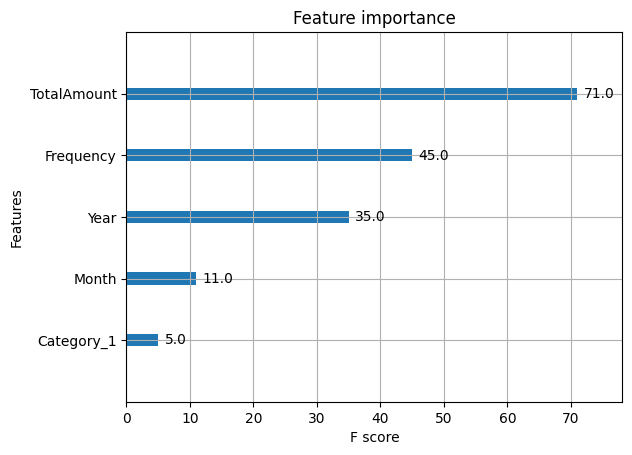

In [144]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_cl)
plt.show()

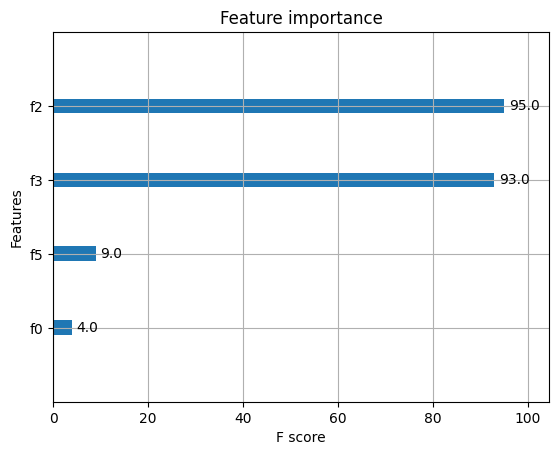

In [145]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_clf)
plt.show()

In [146]:
x_train

,Year,Month,Frequency,TotalAmount,Category_0,Category_1,Category_2,Category_3
4287,2017,4,4759,539765.12,1,0,1,1
3129,2010,6,29154,522158.15,0,0,1,1
147,1992,2,2,69.51,1,0,0,0
2868,2008,11,13072,345114.26,0,1,1,1
351,1993,8,1,985.79,1,1,1,0
...,...,...,...,...,...,...,...,...
1603,2001,5,4888,94138.14,0,0,1,1
2491,2006,8,2017,74303.74,1,0,0,0
1345,1999,10,2467,82048.63,1,0,1,0
3220,2010,12,1244,85056.30,1,0,0,1


In [147]:
X_train_scaled

array([[8.96551724e-01, 2.72727273e-01, 1.15407005e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.55172414e-01, 4.54545455e-01, 7.07116523e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.44827586e-02, 9.09090909e-02, 2.42553604e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.75862069e-01, 8.18181818e-01, 5.98137188e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [6.55172414e-01, 1.00000000e+00, 3.01494130e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.65517241e-01, 4.54545455e-01, 8.44329097e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

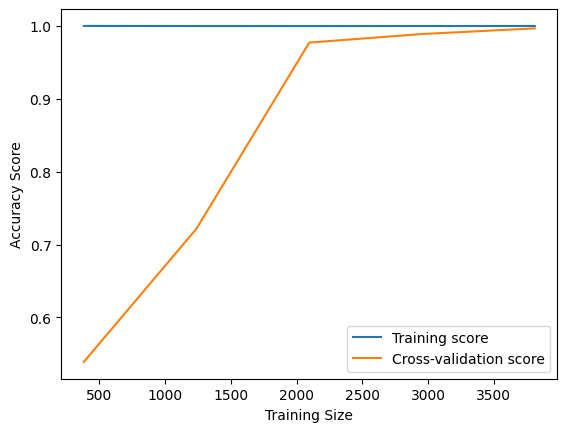

In [148]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb_cl, x, y, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
     

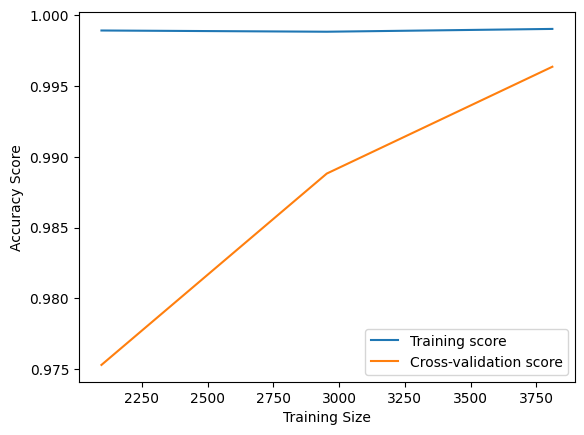

In [149]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb_clf, x, y, cv=5, scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend()

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'TotalAmount'}>,
        <Axes: title={'center': 'Priority'}>,
        <Axes: title={'center': 'Category_0'}>],
       [<Axes: title={'center': 'Category_1'}>,
        <Axes: title={'center': 'Category_2'}>,
        <Axes: title={'center': 'Category_3'}>]], dtype=object)

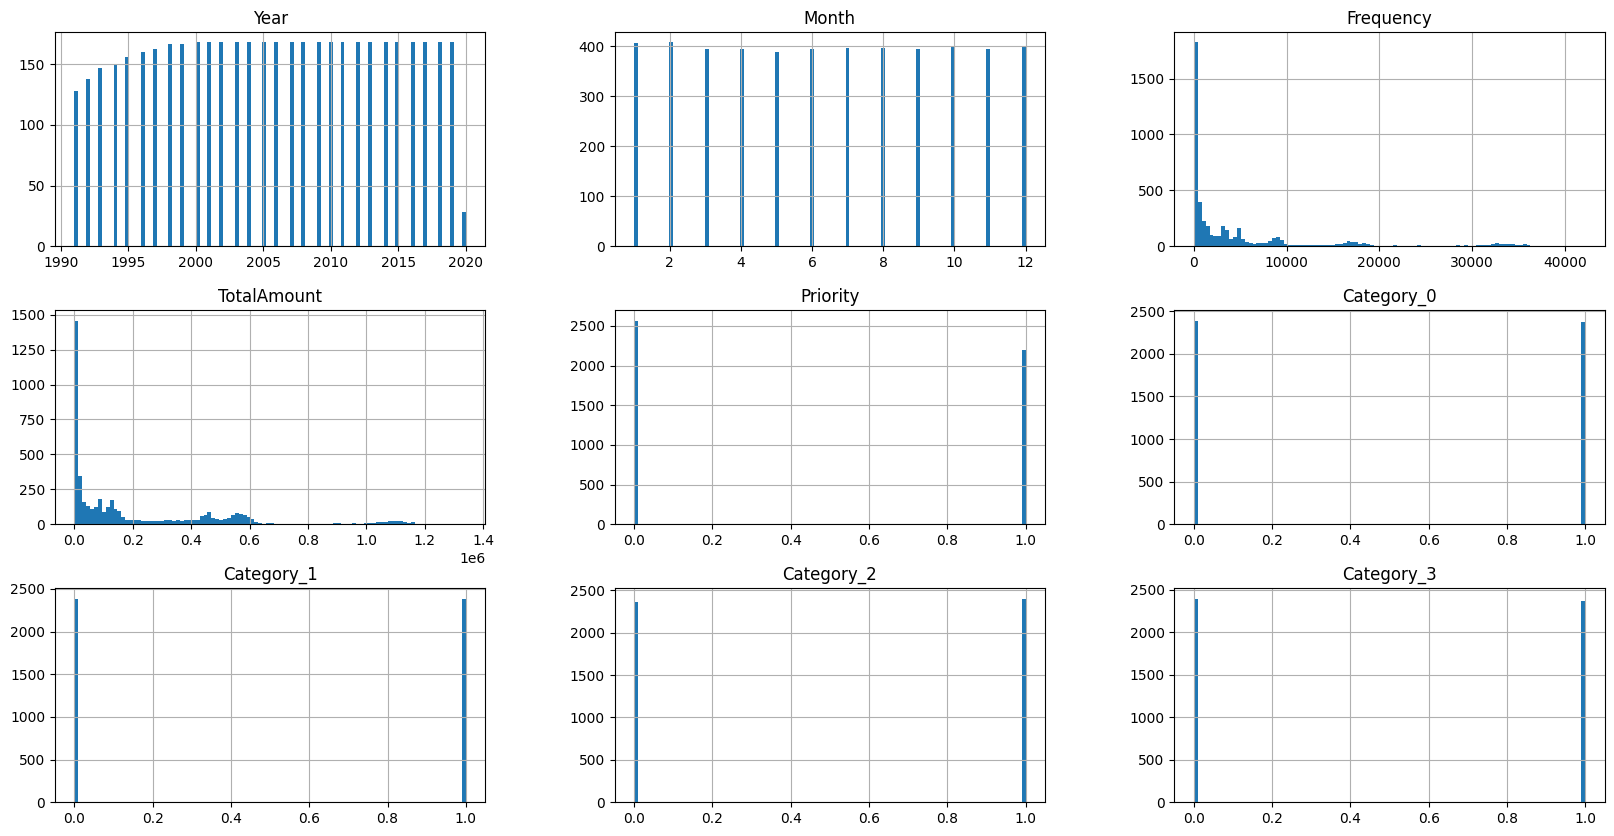

In [150]:
data.hist(bins=100, figsize=(20,10)) 

In [151]:
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# # Calculate theoretical quantiles
# theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(data)))

# # Sort the data
# sorted_data = np.sort(data)

# # Calculate sample quantiles
# sample_quantiles = sorted_data[np.round(np.linspace(0, len(sorted_data) - 1, len(data))).astype(int)]

# # Ensure both arrays have the same length
# min_length = min(len(theoretical_quantiles), len(sample_quantiles))
# theoretical_quantiles = theoretical_quantiles[:min_length]
# sample_quantiles = sample_quantiles[:min_length]

# # Plot the QQ plot
# plt.figure(figsize=(8, 6))
# plt.scatter(theoretical_quantiles, sample_quantiles, s=10)
# plt.title('QQ Plot')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Sample Quantiles')
# plt.show()


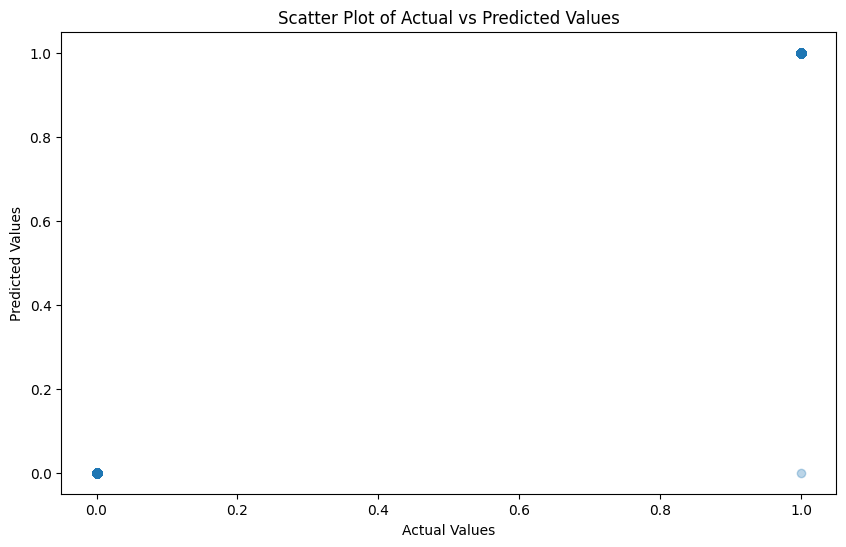

In [152]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.show()

In [153]:
# Define the parameter grid for random search
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the XGBoost classifier
xgb_cll = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform random search for hyperparameter tuning
random_search = RandomizedSearchCV(xgb_clf, param_grid, n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1)
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Create the final XGBoost classifier with the best hyperparameters
final_xgb_clf = xgb.XGBClassifier(**best_params)
final_xgb_clf.fit(x_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [155]:
y_pred=final_xgb_clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, final_xgb_clf.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")


Confusion Matrix:
[[514   0]
 [  1 438]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       439

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953


Accuracy Score:
Accuracy: 0.9990

Precision Score:
Precision: 1.0000

Recall Score:
Recall: 0.9977

Precision-Recall AUC: 1.0000


In [164]:
Grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
Grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params1 = Grid_search.best_params_

# Create the final XGBoost classifier with the best hyperparameters
final_xgb_clf1 = xgb.XGBClassifier(**best_params1)
final_xgb_clf1.fit(x_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [166]:
print(Grid_search.best_params_)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


In [167]:
y_pred=final_xgb_clf1.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, final_xgb_clf1.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")


Confusion Matrix:
[[514   0]
 [  1 438]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       439

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953


Accuracy Score:
Accuracy: 0.9990

Precision Score:
Precision: 1.0000

Recall Score:
Recall: 0.9977

Precision-Recall AUC: 1.0000
